In [1]:
import subprocess
from random import random, randint
from nfa_lib import NFA, random_matrix_for_nfa, count_nfa
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
from tqdm.auto import tqdm as tqdm
import pandas as pd
import pickle
from multiprocessing import Pool, TimeoutError
sns.set(rc={"figure.figsize": (14,10)})

In [302]:
def random_run():
    n_states = randint(2, 20)
    sparsity = round(random() / 2 + 0.5, 2)
    n_initial = randint(1, min(n_states, 5))
    n_final = randint(1, min(n_states, 5))
    string_length = randint(6, 20)
    rand_matrix = random_matrix_for_nfa(n_states=n_states, sparsity=sparsity, n_initial=n_initial, n_final=n_final)
    rand_nfa = NFA.from_random_matrix(rand_matrix)
    rand_nfa_text = rand_nfa.to_text()
    
    res_array = []
    
    epsilon = round(random() * 45 + 5, 1) # epsilon \in [5, 50]
    kappa_multiple = 1
    phi_multiple = round(2 ** (5 + random() * 5)) # phi_multiple \in [32, 1024]

    cpp_input = f"{string_length} {epsilon} {kappa_multiple} {phi_multiple}\n" + rand_nfa_text
    program = ["timeout", "60", "./cpp/main"]
    result = subprocess.run(program, 
                            stdout=subprocess.PIPE, 
                            input=cpp_input,
                            encoding="utf-8")
    res_dict = {}
    if result.returncode == 0:
        invalid = False
        for line in result.stdout.split("\n"):
            if "Got 0 when" in line or "Empty NFA" in line:
                invalid = True
                break
            l_split = line.split()
            if len(l_split) == 2:
                k, v = l_split
                res_dict[k] = float(v) if "." in v else int(v)
        if not invalid:
            res_dict["n_states"] = len(rand_nfa.states)
            res_dict["sparsity"] = sparsity
            res_dict["str_repr"] = cpp_input
            res_dict["string_len"] = string_length
            res_dict["epsilon"] = epsilon
            res_dict["kappa_multiple"] = kappa_multiple
            res_dict["phi_multiple"] = phi_multiple
            res_array.append(res_dict)


    return res_array

In [304]:
# results = []
samples = 0
errors = []
error_count = 0
n_proc = 6
with Pool(processes=n_proc) as pool:
    while error_count < 3:
        multiproc_results = [pool.apply_async(random_run) 
                             for i in range(6*n_proc)]
        for res_promise in tqdm(multiproc_results):
            res = None
            try:
                res = res_promise.get()
            except TimeoutError:
                continue

            if isinstance(res, Exception):
                errors.append(res)
                error_count += 1
                continue
            else:
                samples += 1
                if res:
                    results.extend(res)

        with open("cpp_random.pkl", "wb") as fd:
            pickle.dump(results, fd)
        print(f"Wrote pickle file for {len(results)} results")

100%|███████████████████████████████████████████| 36/36 [01:13<00:00,  2.04s/it]


Wrote pickle file for 499 results


100%|███████████████████████████████████████████| 36/36 [02:02<00:00,  3.40s/it]


Wrote pickle file for 529 results


100%|███████████████████████████████████████████| 36/36 [01:05<00:00,  1.81s/it]


Wrote pickle file for 551 results


100%|███████████████████████████████████████████| 36/36 [01:08<00:00,  1.90s/it]


Wrote pickle file for 578 results


100%|███████████████████████████████████████████| 36/36 [01:34<00:00,  2.62s/it]


Wrote pickle file for 603 results


100%|███████████████████████████████████████████| 36/36 [01:32<00:00,  2.57s/it]


Wrote pickle file for 631 results


100%|███████████████████████████████████████████| 36/36 [01:38<00:00,  2.74s/it]


Wrote pickle file for 654 results


  6%|██▍                                         | 2/36 [00:01<00:23,  1.43it/s]


KeyboardInterrupt: 

In [3]:
with open("cpp_random.pkl", "rb") as fd:
    results = pickle.load(fd)

In [4]:
df = pd.DataFrame(results)

In [5]:
df["rel_error"] = abs(df.estimation - df.bruteforce)/df.bruteforce

<IPython.core.display.Javascript object>


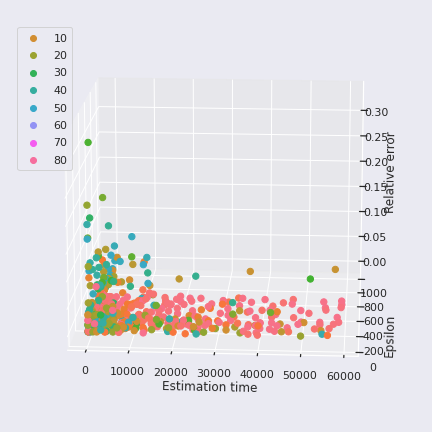

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df.estimation_time, df.phi_multiple, df.rel_error, s=40, c=df.epsilon,
                marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Estimation time')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Relative error')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(0.18, 0.95), loc=0)

In [50]:
df[(df.rel_error > 0) & (df.epsilon < 2)].sort_values(by="rel_error", ascending=False).drop(columns=["str_repr"])

,retries_per_sample,sample_size,sample_misses,sample_hits,miss_ratio,bruteforce,bruteforce_time,estimation,estimation_time,n_states,sparsity,string_len,epsilon,kappa_multiple,phi_multiple,rel_error
173,489668,1250,97389,195000,0.499431,1024,46,1038.1200,22086,17,0.66,10,1.28,1,100,0.013789
208,481145,1096,0,170976,0.000000,1024,46,1034.5300,17006,17,0.66,10,1.46,1,350,0.010283
54,361852,174,0,5046,0.000000,64,0,64.5977,59,5,0.65,6,1.14,1,450,0.009339
20,390810,272,0,7888,0.000000,64,0,64.5882,89,5,0.65,6,0.73,1,175,0.009191
189,470916,936,1582,146016,0.010834,1024,46,1014.8800,15548,17,0.66,10,1.71,1,150,0.008906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,556093,3483,0,508518,0.000000,4096,175,4096.5400,40198,13,0.54,12,0.51,1,500,0.000132
112,496456,1388,0,202648,0.000000,4096,175,4095.5100,21696,13,0.54,12,1.28,1,200,0.000120
183,592989,6154,0,960024,0.000000,1024,46,1024.1100,58936,17,0.66,10,0.26,1,500,0.000107
89,567153,4131,7868,603126,0.013045,4096,175,4095.6300,43999,13,0.54,12,0.43,1,150,0.000090


In [54]:
%%time
probe = df.loc[173]
cpp_input_nfa = probe.str_repr
cpp_input_nfa = cpp_input_nfa[cpp_input_nfa.find("\n") :]
str_len = probe.string_len
ests = []
for phi in tqdm([25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]):
    eps = round(1000/phi, 5)
    cpp_input = f'{str_len} {eps} 1 {phi}\n{cpp_input_nfa}'
    for i in range(5):
        result = subprocess.run(["timeout", "300", "./cpp/main"], 
                                    stdout=subprocess.PIPE, 
                                    input=cpp_input,
                                    encoding="utf-8")
        res_dict2 = {}
        if result.returncode == 0:
            invalid = False
            for line in result.stdout.split("\n"):
                if "Got 0 when" in line or "Empty NFA" in line:
                    print(line)
                    invalid = True
                    break
                l_split = line.split()
                if len(l_split) == 2:
                    k, v = l_split
                    res_dict2[k] = float(v) if "." in v else int(v)
            if not invalid:
                res_dict2["epsilon"] = eps
                res_dict2["phi_multiple"] = phi
                ests.append(res_dict2)

100%|███████████████████████████████████████████| 14/14 [09:25<00:00, 40.39s/it]

CPU times: user 67.2 ms, sys: 245 ms, total: 312 ms
Wall time: 9min 25s


In [55]:
df_probe = pd.DataFrame(ests)

In [56]:
df_probe["rel_error"] = abs(df_probe.estimation - probe.bruteforce)/probe.bruteforce

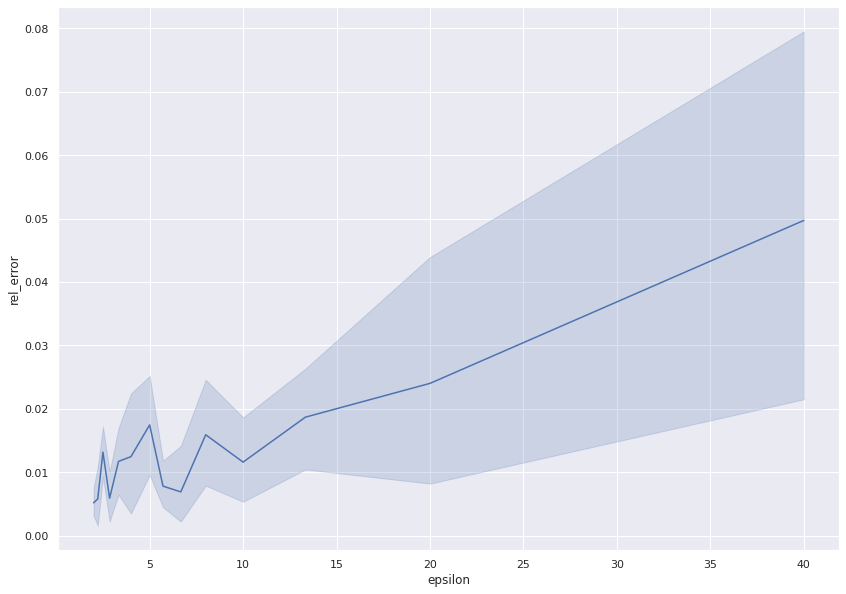

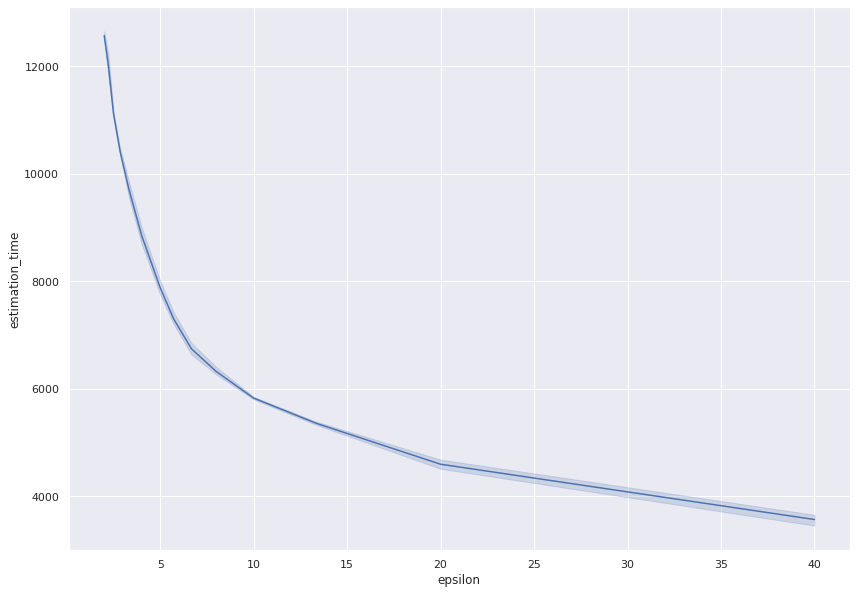

<AxesSubplot:xlabel='phi_multiple', ylabel='rel_error'>

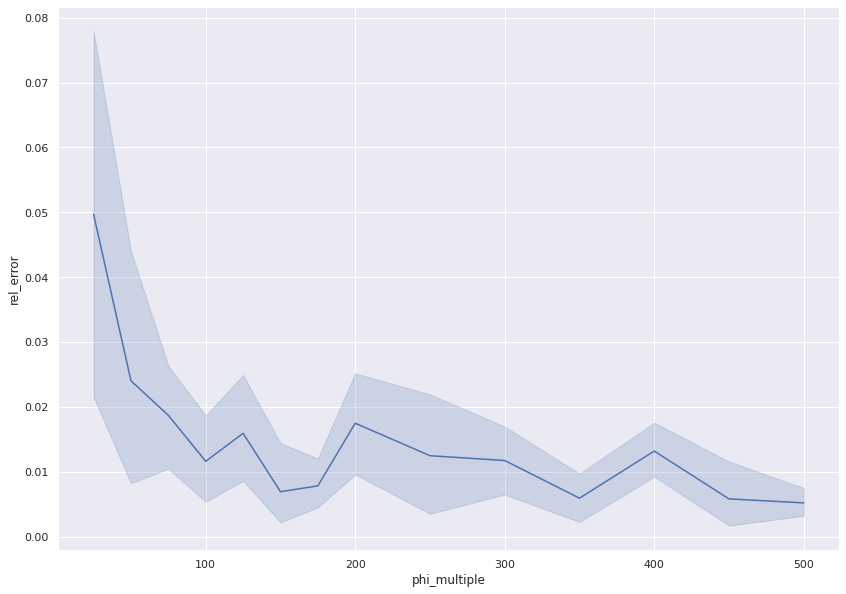

In [61]:
%matplotlib inline
sns.set(rc={"figure.figsize": (14,10)})
sns.lineplot(data=df_probe, x="epsilon", y="rel_error")
plt.show()
sns.lineplot(data=df_probe, x="epsilon", y="estimation_time")
plt.show()
sns.lineplot(data=df_probe, x="phi_multiple", y="rel_error")

# Pentanacci NFA

In [86]:
rand_matrix = np.array(
   [[0, 0, 1, 0, 1, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 1, 0, 1, 0, 0],
   [0, 1, 0, 0, 1, 0],
   [0, 0, 0, 0, 0, 0],
   [1, 1, 0, 1, 0, 0],
   [1, 0, 0, 0, 1, 0],
   [1, 0, 0, 0, 0, 1],
   [0, 1, 1, 1, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 1, 0, 1, 0, 1],
   [0, 0, 1, 0, 0, 0],
   [0, 0, 0, 1, 0, 1],
   [1, 0, 0, 0, 1, 0]])

array([[0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0]])

In [78]:
data = [rand_nfa.bruteforce_count_only(i) for i in range(26)]

In [81]:
[data[i+1] / data[i] for i in range(1, 25)]

[2.0,
 3.5,
 2.142857142857143,
 1.8666666666666667,
 2.0,
 1.9821428571428572,
 1.954954954954955,
 1.9631336405529953,
 1.9671361502347418,
 1.9665871121718377,
 1.9660194174757282,
 1.9657407407407408,
 1.965928717224054,
 1.9659771583739318,
 1.9659571010724732,
 1.965946191676654,
 1.9659449232709691,
 1.9659484602224122,
 1.965948802184324,
 1.9659483110412075,
 1.9659481587913195,
 1.9659481928633655,
 1.9659482494953409,
 1.9659482458453843]

In [82]:
data

[0,
 1,
 2,
 7,
 15,
 28,
 56,
 111,
 217,
 426,
 838,
 1648,
 3240,
 6369,
 12521,
 24616,
 48394,
 95140,
 187040,
 367711,
 722901,
 1421186,
 2793978,
 5492816,
 10798592,
 21229473]

In [85]:
print(rand_nfa.to_text())

6 2 20
0 1 2 3 4 5
0 0 0 1 0 1
1 0 0 0 1 0
0 1
0 0 4
0 0 2
0 1 4
0 1 0
1 1 5
1 1 0
2 0 1
2 0 3
2 1 2
2 1 1
2 1 3
3 0 4
3 0 1
4 1 5
4 1 1
4 1 3
5 0 0
5 0 1
5 0 3
5 1 2
